# Enzyme Project
## Cascade Plot

In [1]:
library(dplyr)
library(ggplot2)
library(cowplot)
library(magrittr)
library(tidyr)
library(broom)
library(splines)
library(scales)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



In [2]:
fig6a <- read.csv("../rawdata/fig6a.csv")

In [3]:
sum(fig6a$b1)

[1] 48.04838

In [4]:
normal.vector <- colSums(fig6a)/100

Normalizing all data to a sum equal to sum of buffer normalized fliuorescence intensities

In [5]:
normal.vector[1] = 1

In [6]:
normal.vector

Distance        b1        b2        t1        t2 
1.0000000 0.4804838 0.4788095 0.5040187 0.5354966

In [7]:
fig6a <- mapply("/",fig6a,normal.vector)

In [8]:
colSums(fig6a)

Distance       b1       b2       t1       t2 
27770.62   100.00   100.00   100.00   100.00

In [9]:
fig6a <- as.data.frame(fig6a)

In [10]:
# Putting data in tidy format
fig2m <- gather(fig6a,"Experiment","Concentration",b1:t2)
head(fig2m)

,Distance,Experiment,Concentration
1,0,b1,0
2,1.8884,b1,0
3,3.7768,b1,0
4,5.6652,b1,0
5,7.5535,b1,0
6,9.4419,b1,0


Next we specify the model. The solution for our initial conditions is $a * erf(\frac{x-c}{\sqrt{4Dt}}) +b$, where $c$ is the step point at $t=0$, and $a$ and $b$ are determined by inital concentrations. As the geometry is also subject to noise, we add two offset parameters for the inital concentration profile (the locations of the channel limits).

We then fit the model using the `nls` R package. We also use the confidence intervals given by the package to fit the upper and lower bounds of the model.

In [11]:
erf <- function(x) 2*pnorm(x*sqrt(2)) -1
# fig2mgroup <- fig2m %>% group_by(variable)
# models <- list()
m <- function(df) {
    mod <- nls(Concentration ~ alph*(erf((Distance+offset1-100)/sqrt(4*Dt1)) - erf((Distance+offset2-220)/sqrt(4*Dt2))), data = df)
    pred <- fitted(mod)
    data.frame(df,pred)
    params = confint(mod, level= 0.95)
    cc <- coef(mod)
    l <- params[,1]
    u <- params[,2]
    lwr <- l[1]*(erf((df$Distance+l[2]-100)/sqrt(4*l[3])) - erf((df$Distance+u[4]-220)/sqrt(4*l[5])))
    upr <- u[1]*(erf((df$Distance+u[2]-100)/sqrt(4*u[3])) - erf((df$Distance+l[4]-220)/sqrt(4*u[5])))
    data.frame(df,pred,lwr,upr,cc[2],cc[4])
}
result <- fig2m %>% group_by(Experiment) %>% do(m(.))
models <- fig2m %>% group_by(Experiment) %>% do(model = nls(Concentration ~ alph*(erf((Distance+offset1-100)/sqrt(4*Dt1)) - erf((Distance+offset2-220)/sqrt(4*Dt2))), data = .))
library(plyr)
result <- rename(result,c("cc.2."="offsetleft","cc.4."="offsetright"))
glimpse(result)


Warning message:
In nls(Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * : No starting values specified for some parameters.
Initializing ‘alph’, ‘offset1’, ‘Dt1’, ‘offset2’, ‘Dt2’ to '1.'.
Consider specifying 'start' or using a selfStart modelWaiting for profiling to be done...
Warning message:
In data.frame(df, pred, lwr, upr, cc[2], cc[4]): row names were found from a short variable and have been discardedWarning message:
In nls(Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * : No starting values specified for some parameters.
Initializing ‘alph’, ‘offset1’, ‘Dt1’, ‘offset2’, ‘Dt2’ to '1.'.
Consider specifying 'start' or using a selfStart modelWaiting for profiling to be done...
Warning message:
In data.frame(df, pred, lwr, upr, cc[2], cc[4]): row names were found from a short variable and have been discardedWarning message:
In nls(Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * : No starting values specified for some parameters.
Initia

Observations: 688
Variables: 8
$ Distance      (dbl) 0.0000, 1.8884, 3.7768, 5.6652, 7.5535, 9.4419, 11.33...
$ Experiment    (fctr) b1, b1, b1, b1, b1, b1, b1, b1, b1, b1, b1, b1, b1, ...
$ Concentration (dbl) 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ pred          (dbl) 2.986087e-09, 5.238870e-09, 9.114323e-09, 1.572409e-0...
$ lwr           (dbl) 1.569790e-09, 2.804232e-09, 4.966186e-09, 8.719092e-0...
$ upr           (dbl) 5.561151e-09, 9.587549e-09, 1.639510e-08, 2.780907e-0...
$ offsetleft    (dbl) -20.86433, -20.86433, -20.86433, -20.86433, -20.86433...
$ offsetright   (dbl) 9.411884, 9.411884, 9.411884, 9.411884, 9.411884, 9.4...


In [12]:
#adding channel data
result$channel <- 0
result$channel[result$Distance <= 100] <- 'left'
result$channel[result$Distance > 100 & result$Distance <= 220] <- 'center'
result$channel[result$Distance > 220] <- 'right'
glimpse(result)

Observations: 688
Variables: 9
$ Distance      (dbl) 0.0000, 1.8884, 3.7768, 5.6652, 7.5535, 9.4419, 11.33...
$ Experiment    (fctr) b1, b1, b1, b1, b1, b1, b1, b1, b1, b1, b1, b1, b1, ...
$ Concentration (dbl) 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ pred          (dbl) 2.986087e-09, 5.238870e-09, 9.114323e-09, 1.572409e-0...
$ lwr           (dbl) 1.569790e-09, 2.804232e-09, 4.966186e-09, 8.719092e-0...
$ upr           (dbl) 5.561151e-09, 9.587549e-09, 1.639510e-08, 2.780907e-0...
$ offsetleft    (dbl) -20.86433, -20.86433, -20.86433, -20.86433, -20.86433...
$ offsetright   (dbl) 9.411884, 9.411884, 9.411884, 9.411884, 9.411884, 9.4...
$ channel       (chr) "left", "left", "left", "left", "left", "left", "left...


In [13]:
detach("package:plyr", unload=TRUE)

Warning message:
: ‘plyr’ namespace cannot be unloaded:
  namespace ‘plyr’ is imported by ‘scales’, ‘ggplot2’, ‘reshape2’, ‘broom’ so cannot be unloaded

In [14]:
groupy <- group_by(result,channel,Experiment)
summed <- summarise(groupy, pred = sum(pred), lwr = sum(lwr), upr = sum(upr), actual = sum(Concentration))
names(summed)[2] = 'experiment'
summed <- gather(summed, "variable","value", c(pred,actual))
summed$upr[summed$variable == 'actual'] <- NaN
summed$lwr[summed$variable == 'actual'] <- NaN

In [15]:
head(result)

,Distance,Experiment,Concentration,pred,lwr,upr,offsetleft,offsetright,channel
1,0,b1,0,2.986087e-09,1.56979e-09,5.561151e-09,-20.86433,9.411884,left
2,1.8884,b1,0,5.23887e-09,2.804232e-09,9.587549e-09,-20.86433,9.411884,left
3,3.7768,b1,0,9.114323e-09,4.966186e-09,1.63951e-08,-20.86433,9.411884,left
4,5.6652,b1,0,1.572409e-08,8.719092e-09,2.780907e-08,-20.86433,9.411884,left
5,7.5535,b1,0,2.689994e-08,1.51757e-08,4.678601e-08,-20.86433,9.411884,left
6,9.4419,b1,0,4.563619e-08,2.618689e-08,7.80781e-08,-20.86433,9.411884,left


In [16]:
result %<>% group_by(Experiment) %>% mutate(Experiment.Type = substring(Experiment,1,1) )

In [17]:
control.conc = filter(result, Experiment.Type == 'b')$Concentration
control.pred = filter(result, Experiment.Type == 'b')$pred
result %<>% group_by(Experiment.Type)%>% mutate(control.concentration = control.conc,control.pred = control.pred)
result %<>% ungroup()


In [18]:
summed %<>% rename(Substrate = experiment)
control.conc <- filter(summed, Substrate == 'Buffer')$value
control.lwr <- filter(summed, Substrate == 'Buffer')$lwr
control.upr <- filter(summed, Substrate == 'Buffer')$upr
summed %<>% group_by(Substrate) %>% mutate(control.concentration = control.conc,control.lwr = control.lwr,
                                           control.upr = control.upr)
summed %<>% ungroup()


ERROR: Error in eval(expr, envir, enclos): impossible to replicate vector of size 0


In [19]:
head(result)

,Distance,Experiment,Concentration,pred,lwr,upr,offsetleft,offsetright,channel,Experiment.Type,control.concentration,control.pred
1,0,b1,0,2.986087e-09,1.56979e-09,5.561151e-09,-20.86433,9.411884,left,b,0,2.986087e-09
2,1.8884,b1,0,5.23887e-09,2.804232e-09,9.587549e-09,-20.86433,9.411884,left,b,0,5.23887e-09
3,3.7768,b1,0,9.114323e-09,4.966186e-09,1.63951e-08,-20.86433,9.411884,left,b,0,9.114323e-09
4,5.6652,b1,0,1.572409e-08,8.719092e-09,2.780907e-08,-20.86433,9.411884,left,b,0,1.572409e-08
5,7.5535,b1,0,2.689994e-08,1.51757e-08,4.678601e-08,-20.86433,9.411884,left,b,0,2.689994e-08
6,9.4419,b1,0,4.563619e-08,2.618689e-08,7.80781e-08,-20.86433,9.411884,left,b,0,4.563619e-08


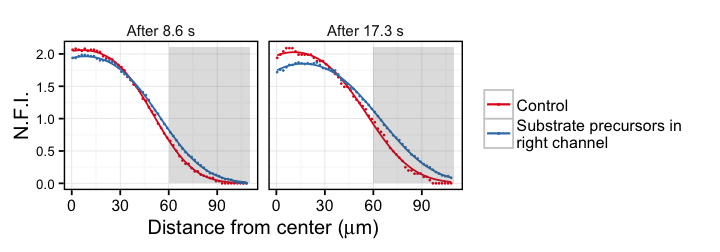

In [38]:
options(repr.plot.width = 6, repr.plot.height = 2.1)
cols <- hue_pal()(2)

xmin = 0
xmax = 110

raw <- ggplot(data = filter(result,Experiment.Type != "b",Distance-160>=xmin,Distance-160 <=xmax),aes(x = Distance-160,y = Concentration,color = cols[1])) + 
    geom_line(aes(y = control.pred,color = cols[2])) +
    geom_point(size = 0.1,aes(y = control.concentration,color = cols[2])) +
    geom_point(size = 0.1) +
    geom_line(aes(y = pred)) +
    ylab("N.F.I.") +
    xlab(expression(paste("Distance from center (", mu, "m)", sep = ""))) +
    scale_color_brewer(palette='Set1',labels = c("Control","Substrate precursors in\nright channel")) +
    facet_grid(. ~ Experiment,
               labeller = labeller(Experiment =c(t1 = 'After 8.6 s',t2 = 'After 17.3 s'))) +
    theme_bw() +     
    theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=8),
        legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA)
#          legend.position='bottom') +
          )+
#     annotate("rect", xmin = xmin, xmax = -60, ymin = 0.000025, ymax = +1.00091, alpha = .2)
    annotate("rect", xmin = 60, xmax = xmax, ymin = 0.000025, ymax = +2.1, alpha = .2)
#     scale_x_continuous(limits = c(-120, -20))

    
print(raw)

### Redoing part 2 of the graph

In [23]:
cascade.DF <- read.csv("../rawdata/cascade_time.csv")

In [24]:
cascade.DF$Experiment <- factor(cascade.DF$Experiment,levels = c ('Glucose.Channel','Glucose.Mannose.Channel','Ald'))
cascade.DF$Time <- as.factor(cascade.DF$Time)

In [25]:
options(repr.plot.width = 5, repr.plot.height = 2)
barchart <- ggplot(data = cascade.DF , 
                     aes(x=Time, y= Enzyne,fill = Experiment)) + 
    geom_bar(stat = "identity",position = "dodge") +
    xlab("Time (s)") +
    ylab("Enzyme %") +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=8),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line())+
    geom_errorbar(aes(ymin = Enzyne-StDev,ymax = Enzyne+StDev ),position = position_dodge(.9), width = 0) +
scale_fill_manual(values = c ("#e41a1c","#377eb8","#a6cee3"),labels = 
                  c("HK in Glucose Channel","HK in Glu-Mannose Channel","Aldolase in Glucose Channel"))

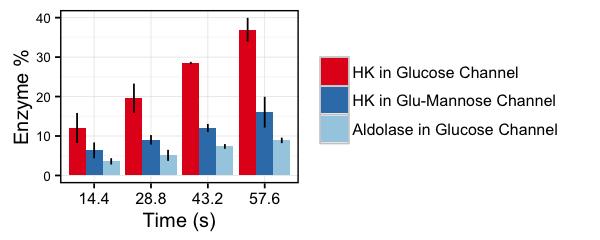

In [26]:
print(barchart)

### Redoing graph 6

In [27]:
fig6.DF <- read.csv("../rawdata/fig6v2.csv")

Warning message:
In read.table(file = file, header = header, sep = sep, quote = quote, : incomplete final line found by readTableHeader on '../rawdata/fig6v2.csv'

In [28]:
fig6.DF

,time,conc,experiment,stdev
1,43.2,5.25,hk,0.7
2,57.6,9.86,hk,1.4
3,43.2,1.99,ald,0.3
4,57.6,3.37,ald,1


In [29]:
fig6.DF$time <- as.factor(fig6.DF$time)
fig6.DF$experiment <- factor(fig6.DF$experiment,levels=c("hk","ald"))

In [30]:
options(repr.plot.width = 4.6, repr.plot.height = 2)
barchart2 <- ggplot(data = fig6.DF , 
                     aes(x=time, y= conc,fill = experiment)) + 
    geom_bar(stat = "identity",position = "dodge") +
    xlab("Time (s)") +
    ylab("Enzyme %") +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=8),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line())+
    geom_errorbar(aes(ymin = conc-stdev,ymax = conc+stdev ),position = position_dodge(.9), width = 0) +
scale_fill_manual(values = c ("#e41a1c","#a6cee3"),labels = 
                  c("HK in Glucose Channel","Aldolase in Glucose Channel"))

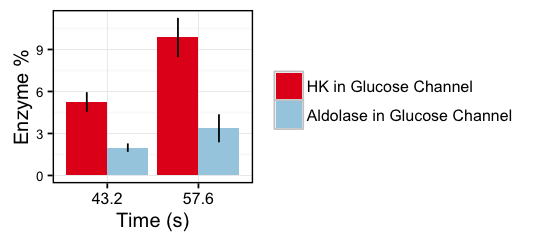

In [31]:
print(barchart2)

In [32]:
ggsave("./img/fig6v2.png",width = 4.6, height = 2)

ERROR: Error in grDevices::dev.off(): QuartzBitmap_Output - unable to open file './img/fig6v2.png'


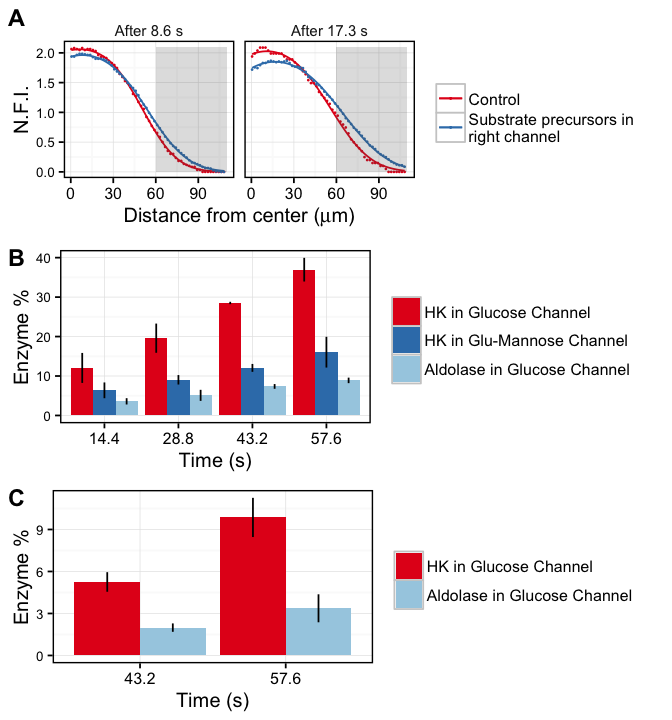

In [39]:
options(repr.plot.width = 5.6, repr.plot.height = 6)

plot_grid(raw,barchart,barchart2, labels = c("A","B","C"),ncol = 1)

In [40]:
ggsave("../img/fig6v5.png",width = 5.6, height = 6)